In [21]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import datetime
from pandas_datareader import data as pdr
yf.pdr_override()

In [22]:
company = "AMZN"
start_date = "2015-01-01"
end_date = "2024-01-01"
data = yf.download(company, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [23]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2264.000000,2264.000000,2264.000000,2264.000000,2264.000000,2.264000e+03
mean,91.980237,93.048392,90.813574,91.950540,91.950540,8.005899e+07
std,48.697243,49.303374,48.034871,48.654536,48.654536,4.063687e+07
min,14.314000,14.539500,14.262500,14.347500,14.347500,1.762600e+07
25%,44.243750,44.635250,44.126499,44.303625,44.303625,5.390508e+07
50%,90.728249,91.489498,89.867252,90.691998,90.691998,6.862200e+07
75%,133.395000,134.802494,131.811623,133.230000,133.230000,9.332950e+07
max,187.199997,188.654007,184.839493,186.570496,186.570496,4.771220e+08


In [24]:
data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,15.6290,15.7375,15.3480,15.4260,15.4260,55664000
2015-01-05,15.3505,15.4190,15.0425,15.1095,15.1095,55484000
2015-01-06,15.1120,15.1500,14.6190,14.7645,14.7645,70380000
2015-01-07,14.8750,15.0640,14.7665,14.9210,14.9210,52806000
2015-01-08,15.0160,15.1570,14.8055,15.0230,15.0230,61768000


In [25]:
data.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-22,153.770004,154.350006,152.710007,153.419998,153.419998,29480100
2023-12-26,153.559998,153.979996,153.029999,153.410004,153.410004,25067200
2023-12-27,153.559998,154.779999,153.119995,153.339996,153.339996,31434700
2023-12-28,153.720001,154.080002,152.949997,153.380005,153.380005,27057000
2023-12-29,153.100006,153.889999,151.029999,151.940002,151.940002,39789000


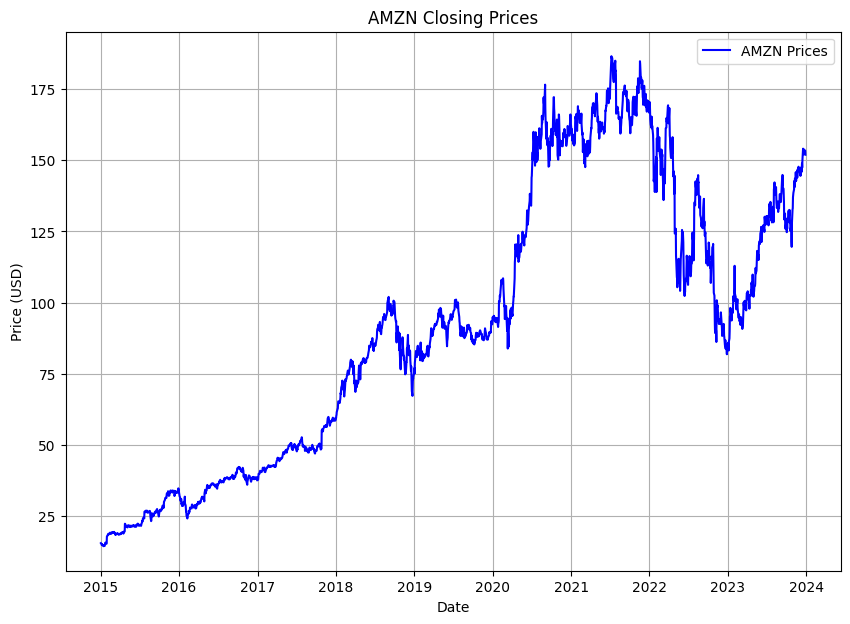

In [26]:
# Select closing prices
prices = data['Close'].values.reshape(-1, 1)
plt.figure(figsize=(10, 7))
plt.plot(data.index, prices, label='AMZN Prices', color='blue')
plt.title('AMZN Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

In [28]:
def prepare_data(data, n_steps):
    x, y = [], []
    for i in range(len(data) - n_steps):
        x.append(data[i:(i + n_steps), 0])
        y.append(data[i + n_steps, 0])
    return np.array(x), np.array(y)

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Code snippet for creating and training the LSTM model
n_steps = 60
# Prepare the training data using the defined function
X ,Y = prepare_data(prices_scaled, n_steps)

train_size = int(0.8 * len(X))
x_train, x_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

# Create an instance of the LSTM model
model = create_lstm_model((x_train.shape[1], 1))

# Train the model on the training data
model.fit(x_train, y_train, epochs=60, batch_size=32, verbose = 1)

Epoch 1/60
56/56 [==============================] - 7s 64ms/step - loss: 0.0191
Epoch 2/60
56/56 [==============================] - 2s 43ms/step - loss: 7.5719e-04
Epoch 3/60
56/56 [==============================] - 2s 44ms/step - loss: 6.7813e-04
Epoch 4/60
56/56 [==============================] - 2s 44ms/step - loss: 6.6878e-04
Epoch 5/60
56/56 [==============================] - 3s 53ms/step - loss: 6.4178e-04
Epoch 6/60
56/56 [==============================] - 3s 56ms/step - loss: 6.4607e-04
Epoch 7/60
56/56 [==============================] - 3s 46ms/step - loss: 6.4025e-04
Epoch 8/60
56/56 [==============================] - 2s 44ms/step - loss: 6.1880e-04
Epoch 9/60
56/56 [==============================] - 2s 44ms/step - loss: 6.1977e-04
Epoch 10/60
56/56 [==============================] - 3s 62ms/step - loss: 5.9800e-04
Epoch 11/60
56/56 [==============================] - 3s 45ms/step - loss: 5.5186e-04
Epoch 12/60
56/56 [==============================] - 2s 43ms/step - loss: 5.40

In [29]:
test_predictions = model.predict(x_test)
train_predictions = model.predict(x_train)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions)
train_predictions = scaler.inverse_transform(train_predictions)

56/56 [==============================] - 1s 14ms/step


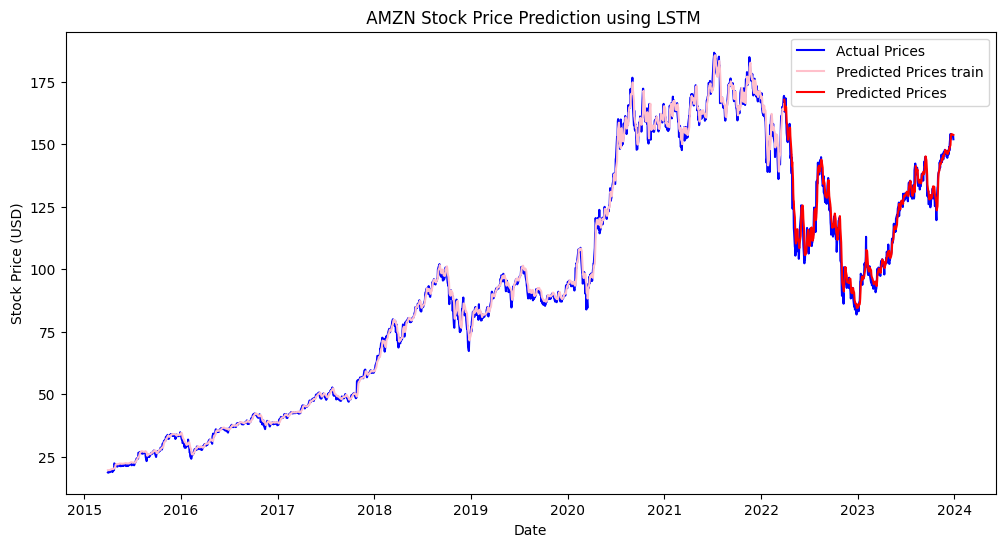

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(data.index[n_steps:], prices[n_steps:], label='Actual Prices', color='blue')
plt.plot(data.index[n_steps:train_size+n_steps], train_predictions, label='Predicted Prices train', color='pink')
plt.plot(data.index[train_size+n_steps:], test_predictions, label='Predicted Prices', color='red')
plt.title(' AMZN Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()

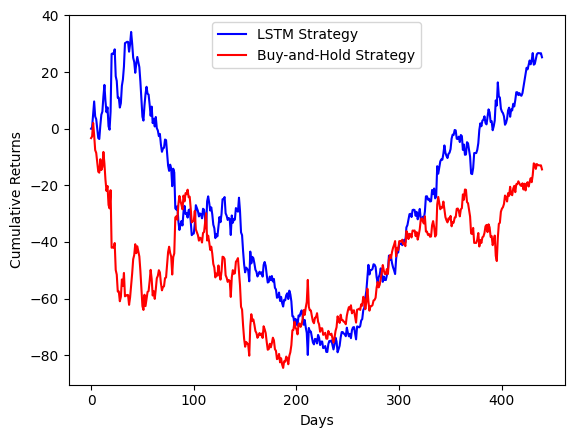

In [38]:
# Flatten y_test and test_predictions arrays
y_test = y_test.flatten()
test_predictions = test_predictions.flatten()

# Initialize signals array with zeros
signals = np.zeros_like(y_test)

# Loop through the predicted values and compare with actual values
for i in range(1, len(test_predictions)):
    if test_predictions[i] > y_test[i]:
        signals[i] = 1  # Buy signal
    elif test_predictions[i] < y_test[i]:
        signals[i] = -1  # Sell signal

# Calculate returns for LSTM strategy and Buy-and-Hold strategy
lstm_returns = signals[:-1] * (y_test[1:] - y_test[:-1])
buy_hold_returns = y_test[1:] - y_test[:-1]

# Calculate cumulative returns for LSTM strategy and Buy-and-Hold strategy
lstm_cumulative_returns = np.cumsum(lstm_returns)
buy_hold_cumulative_returns = np.cumsum(buy_hold_returns)

# Plot cumulative returns over time
plt.plot(lstm_cumulative_returns, label="LSTM Strategy", color = 'blue')
plt.plot(buy_hold_cumulative_returns, label="Buy-and-Hold Strategy", color='red')
plt.xlabel("Days")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()